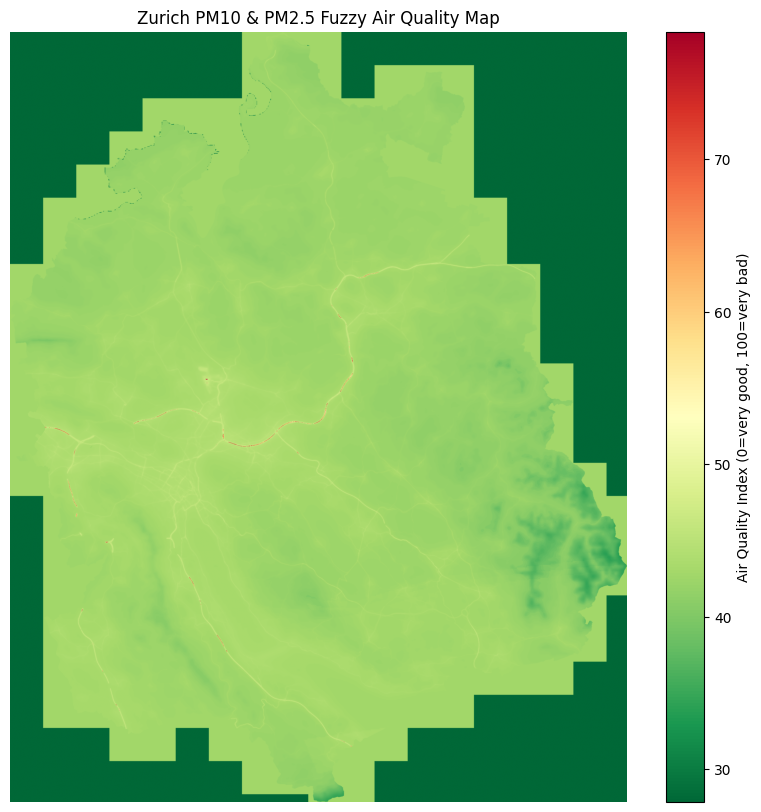

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# --- CONFIGURATION FOR FUZZY VARIABLES ---
fuzzy_inputs = [
    {
        "input_file": "../geoserver_data/data/pm10.tif",
        "max_value": 400,
        "name": "pm10",
        "good": [0, 0, 160],
        "moderate": [150, 230, 310],
        "bad": [300, 320, 400]
    },
    {
        "input_file": "../geoserver_data/data/pm25.tif",
        "max_value": 400,
        "name": "pm25",
        "good": [0, 0, 80],
        "moderate": [75, 160, 235],
        "bad": [200, 240, 400]
    },
    {
        "input_file": "../geoserver_data/data/russ.tif",
        "max_value": 35000,
        "name": "russ",
        "good": [0, 0, 209],
        "moderate": [205, 281, 356],
        "bad": [350, 360, 35000]
    },
    {
        "input_file": "../geoserver_data/data/no2.tif",
        "max_value": 1500,
        "name": "no2",
        "good": [0, 0, 256],
        "moderate": [250, 510, 766],
        "bad": [750, 775, 1500]
    },
    {
        "input_file": "../geoserver_data/data/ozon.tif",
        "max_value": 100,
        "name": "ozon",
        "good": [0, 0, 54],
        "moderate": [50, 74, 93],
        "bad": [90, 95, 100]
    },
    {
        "input_file": "../geoserver_data/data/laerm.tif",
        "max_value": 150,
        "name": "laerm",
        "good": [0, 0, 73],
        "moderate": [70, 80, 88],
        "bad": [85, 95, 150]
    }
]

# --- LOAD RASTERS AND ENSURE CRS CONSISTENCY ---
with rasterio.open(fuzzy_inputs[0]["input_file"]) as ref_src:
    ref_crs = ref_src.crs
    ref_transform = ref_src.transform
    ref_shape = ref_src.read(1).shape

rasters = {}
meta = None

for var in fuzzy_inputs:
    with rasterio.open(var["input_file"]) as src:
        data = src.read(1).astype(float)

        if src.crs != ref_crs:
            reprojected = np.zeros(ref_shape, dtype=float)
            reproject(
                source=data,
                destination=reprojected,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.bilinear
            )
            data = reprojected

        rasters[var["name"]] = data

        if meta is None:
            meta = src.meta.copy()
            meta.update({
                "crs": ref_crs,
                "transform": ref_transform,
                "height": ref_shape[0],
                "width": ref_shape[1]
            })

# --- CREATE FUZZY VARIABLES ---
antecedents = {}

for var in fuzzy_inputs:
    ant = ctrl.Antecedent(np.linspace(0, var["max_value"], var["max_value"] + 1), var["name"])
    ant['good'] = fuzz.trimf(ant.universe, var['good'])
    ant['moderate'] = fuzz.trimf(ant.universe, var['moderate'])
    ant['bad'] = fuzz.trimf(ant.universe, var['bad'])
    antecedents[var['name']] = ant

# --- CONSEQUENT ---
quality = ctrl.Consequent(np.linspace(0, 100, 101), 'quality')
quality['very_good'] = fuzz.trimf(quality.universe, [0, 0, 25])
quality['good'] = fuzz.trimf(quality.universe, [20, 40, 60])
quality['liveable'] = fuzz.trimf(quality.universe, [50, 60, 70])
quality['bad'] = fuzz.trimf(quality.universe, [65, 80, 90])
quality['very_bad'] = fuzz.trimf(quality.universe, [85, 100, 100])

# --- DEFINE RULES (ALL VARIABLES) ---
rules = []

# Very good: all good
rules.append(ctrl.Rule(
    antecedents['pm10']['good'] & antecedents['pm25']['good'] &
    antecedents['russ']['good'] & antecedents['no2']['good'] &
    antecedents['ozon']['good'] & antecedents['laerm']['good'],
    quality['very_good']
))

# Good: at least good, none bad
rules.append(ctrl.Rule(
    (antecedents['pm10']['good'] | antecedents['pm25']['good'] |
     antecedents['russ']['good'] | antecedents['no2']['good'] |
     antecedents['ozon']['good'] | antecedents['laerm']['good']) &
    ~(antecedents['pm10']['bad'] | antecedents['pm25']['bad'] |
      antecedents['russ']['bad'] | antecedents['no2']['bad'] |
      antecedents['ozon']['bad'] | antecedents['laerm']['bad']),
    quality['good']
))

# Liveable: at least moderate, none bad
rules.append(ctrl.Rule(
    (antecedents['pm10']['moderate'] | antecedents['pm25']['moderate'] |
     antecedents['russ']['moderate'] | antecedents['no2']['moderate'] |
     antecedents['ozon']['moderate'] | antecedents['laerm']['moderate']) &
    ~(antecedents['pm10']['bad'] | antecedents['pm25']['bad'] |
      antecedents['russ']['bad'] | antecedents['no2']['bad'] |
      antecedents['ozon']['bad'] | antecedents['laerm']['bad']),
    quality['liveable']
))

# Bad: any bad
rules.append(ctrl.Rule(
    antecedents['pm10']['bad'] | antecedents['pm25']['bad'] |
    antecedents['russ']['bad'] | antecedents['no2']['bad'] |
    antecedents['ozon']['bad'] | antecedents['laerm']['bad'],
    quality['bad']
))

# Very bad: all bad (optional, ensures extreme cases)
rules.append(ctrl.Rule(
    antecedents['pm10']['bad'] & antecedents['pm25']['bad'] &
    antecedents['russ']['bad'] & antecedents['no2']['bad'] &
    antecedents['ozon']['bad'] & antecedents['laerm']['bad'],
    quality['very_bad']
))

quality_ctrl = ctrl.ControlSystem(rules)
quality_sim = ctrl.ControlSystemSimulation(quality_ctrl)

# --- APPLY FUZZY SYSTEM PIXEL-WISE ---
fuzzy_map = np.zeros_like(next(iter(rasters.values())), dtype=float)

flat_data = {var["name"]: rasters[var["name"]].flatten() for var in fuzzy_inputs}
first_key = next(iter(flat_data))
flat_result = np.zeros_like(flat_data[first_key], dtype=float)

for i in range(flat_data[first_key].size):
    for var in fuzzy_inputs:
        quality_sim.input[var["name"]] = flat_data[var["name"]][i]

    try:
        quality_sim.compute()
        flat_result[i] = quality_sim.output['quality']
    except KeyError:
        flat_result[i] = np.nan

fuzzy_map = flat_result.reshape(rasters[first_key].shape)

# --- SAVE AS TIF ---
output_file = "../geoserver_data/data/zurich_fuzzy_quality.tif"
meta.update(dtype=rasterio.float32, count=1)
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(fuzzy_map.astype(rasterio.float32), 1)

# --- PLOT FUZZY MAP ---
plt.figure(figsize=(10, 10))
plt.imshow(fuzzy_map, cmap='RdYlGn_r')  # red=bad, green=good
plt.colorbar(label='Air Quality Index (0=very good, 100=very bad)')
plt.title("Zurich PM10 & PM2.5 Fuzzy Air Quality Map")
plt.axis("off")
plt.show()
